In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import coco
import utils
import model as modellib

from model import log
import coco

import visualize
import matplotlib.pyplot as plt


%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

/Users/luke/.pyenv/versions/3.6.3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/luke/.pyenv/versions/3.6.3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING     

# Create Model & Load Weight

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

# Prepare COCO DataSet

In [17]:
config = coco.CocoConfig()
COCO_DIR = "dataset"  # TODO: enter value here

# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train", 2017)
dataset.prepare()

# Print class names
print(dataset.class_names)

loading annotations into memory...
Done (t=16.53s)
creating index...
index created!
['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [19]:
import json

json_data = open("dataset/videotag/0101_0102/instances.json").read()
data = json.loads(json_data)

videotag_anno = data['annotations']
videotag_imgs = data['images']
videotag_cate = data['categories']

In [43]:
print(videotag_anno[0])
print(videotag_imgs[0])
print(videotag_cate[0])

videotag_img_annos = {}
for image in videotag_imgs:
    annos = []
    image_id = image['id']
    
    for anno in videotag_anno:
        anno_img_id = anno['image_id']
        anno_id = anno['id']
        if anno_img_id == image_id:
            annos.append(anno_id)
            
    videotag_img_annos[str(image_id)] = annos

{'id': '297278', 'x_pos': 0.8944153577661431, 'y_pos': 0.5844961240310077, 'image_id': '199593', 'category_id': 'A10'}
{'id': '199605', 'video_id': '29319', 'file_name': '29319-e31cdc10-ee3b-11e7-bbcd-afbd708e5bbe.jpg', 'current': 2.0, 'date_captured': '2018-01-01 00:04:24', 'width': 640, 'height': 360, 'license': '0'}
{'id': 'A01', 'supercategory': '패션의류', 'name': '정장'}


In [45]:
print(videotag_imgs[1]['id'])
print(videotag_img_annos[videotag_imgs[1]['id']])

199606
['199606', '199606']


# Detect & Extract Region

annotations : [{
  area,         // Number - 영역 넓이(w*h)
  bbox,         // [x,y,width,height], (Array(4))
  category_id,  // int
  id,           // int
  image_id,     // int
  iscrowd,      // 0 or 1 (get anns for given crowd label (False or True))
  segmentation  // Array - mask 데이터 (RLE or [polygon])
}

Processing 1 images
image                    shape: (427, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
score 0.9977894
[ 41 521 221 636]
(640, 17)
1
person
annotation {'area': 9554, 'bbox': [521, 41, 115, 180], 'category_id': 1, 'id': '', 'image_id': 0, 'iscrowd': 0, 'segmentation': {'size': [427, 640], 'counts': b'Yam6<j<9G9nDGg8?mFOl85nF2m81mF0U93dFO^9l13O0O20O10000O01O1O101O00000001O001O010O001N1N2L4J7L301N2N2O00100O100O1000O10O1000000000000001O00000O2O0000001O1O1O1O1O1O1O1lL^F]2d9_M_F`2d9ZMbFc2`9UMgFj2n9N2O1O001O001M3K5D<I7L4L4M2M4N2N2N1O2N2O1N2O2N1N2O2N1M4M5J7G6M10ca1'}}


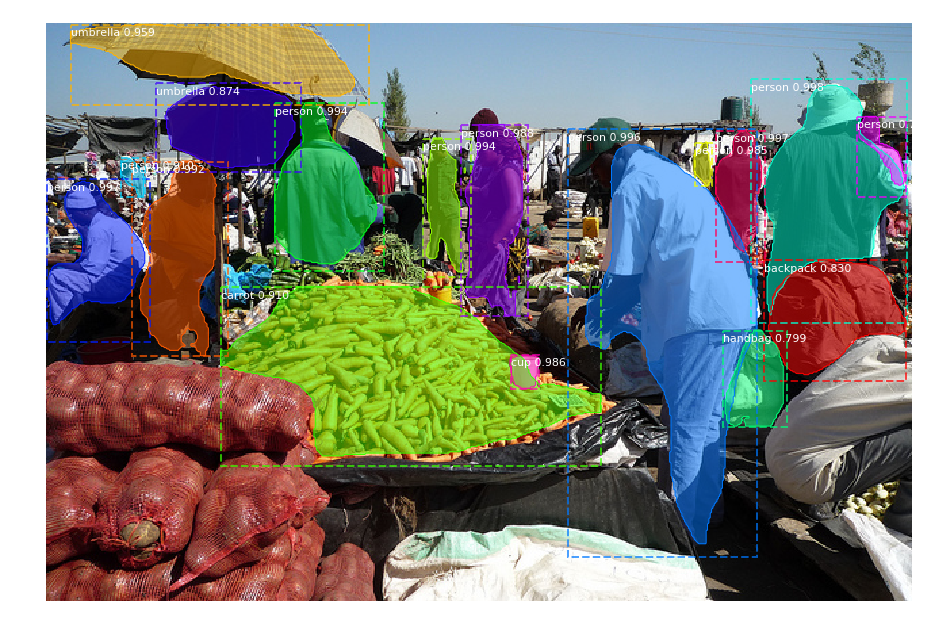

{'rois': array([[ 41, 521, 221, 636],
       [115,   0, 235,  76],
       [ 79, 495, 176, 531],
       [ 78, 385, 394, 525],
       [ 85, 278, 187, 314],
       [ 59, 169, 183, 249],
       [102,  63, 246, 134],
       [ 75, 306, 216, 356],
       [245, 343, 270, 364],
       [ 88, 479, 120, 492],
       [  1,  18,  60, 238],
       [ 99,  55, 128,  73],
       [195, 129, 327, 410],
       [ 44,  81, 110, 188],
       [175, 530, 264, 635],
       [227, 500, 298, 547],
       [ 69, 599, 128, 635]], dtype=int32), 'class_ids': array([ 1,  1,  1,  1,  1,  1,  1,  1, 42,  1, 26,  1, 52, 26, 25, 27,  1],
      dtype=int32), 'scores': array([0.9977894 , 0.99702615, 0.9965251 , 0.99605787, 0.9940274 ,
       0.9937849 , 0.99163425, 0.98816407, 0.98625135, 0.9853607 ,
       0.95930237, 0.9102973 , 0.90960735, 0.8737152 , 0.8304598 ,
       0.7987669 , 0.750028  ], dtype=float32), 'masks': array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
       

In [15]:
from pycocotools import mask as maskUtils

annotations = []

for image_id in dataset.image_ids: 
    image = dataset.load_image(image_id)
    # VIDEOtag Annotation
    
    height, width = image.shape[:2]
    
    # Run detection
    results = model.detect([image], verbose=1)

    # Result
    r = results[0]
    
    rois = r['rois'] # y1, x1, y2, x2
    scores = r['scores']
    masks = r['masks'] # (height, width, 검출된 데이타 갯수)
    class_ids = r['class_ids']
    class_names = dataset.class_names
    
    # 추출된 Annotation을 VIDEOtag Annotation과 비교
    # VIDEOtag Annotation에 bbox
    for index, score in enumerate(scores):
        # if score < 0.95:
        #    continue
            
        print('score', score)
        print(rois[index])
        print(masks[index].shape)
        print(class_ids[index])
        print(class_names[class_ids[index]])
        
        image_id = image_id
        category_id = class_ids[index]
        roi = rois[index]
        bbox = [roi[1], roi[0], roi[3] - roi[1], roi[2] - roi[0]]
        mask = masks[:, :, index]
        segmentation = maskUtils.encode(np.asfortranarray(mask))
        area = maskUtils.area(segmentation)
        
        annotation = {}
        annotation['area'] = area
        annotation['bbox'] = bbox
        annotation['category_id'] = category_id
        annotation['id'] = ''
        annotation['image_id'] = image_id
        annotation['iscrowd'] = 0
        annotation['segmentation'] = segmentation
        
        print('annotation', annotation)
        # Search VIDEOtag Annotation with Point
        
        
        annotations.append(annotation)
        
        break
        
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'])
    print(r)
    break

# Sample Test 1

image_id  92770 http://cocodataset.org/#explore?id=463290
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000
mask                     shape: (480, 640, 20)        min:    0.00000  max:    1.00000
class_ids                shape: (20,)                 min:    1.00000  max:   76.00000
bbox                     shape: (20, 4)               min:   61.00000  max:  640.00000


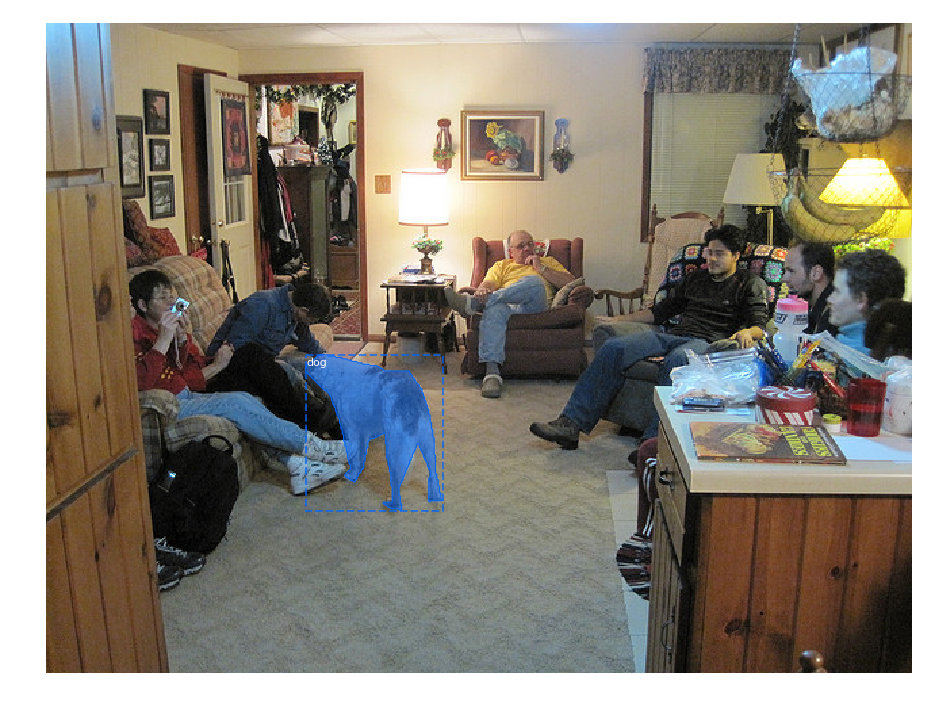

In [14]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

# Sample Test 2

Processing 1 images
image                    shape: (426, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000


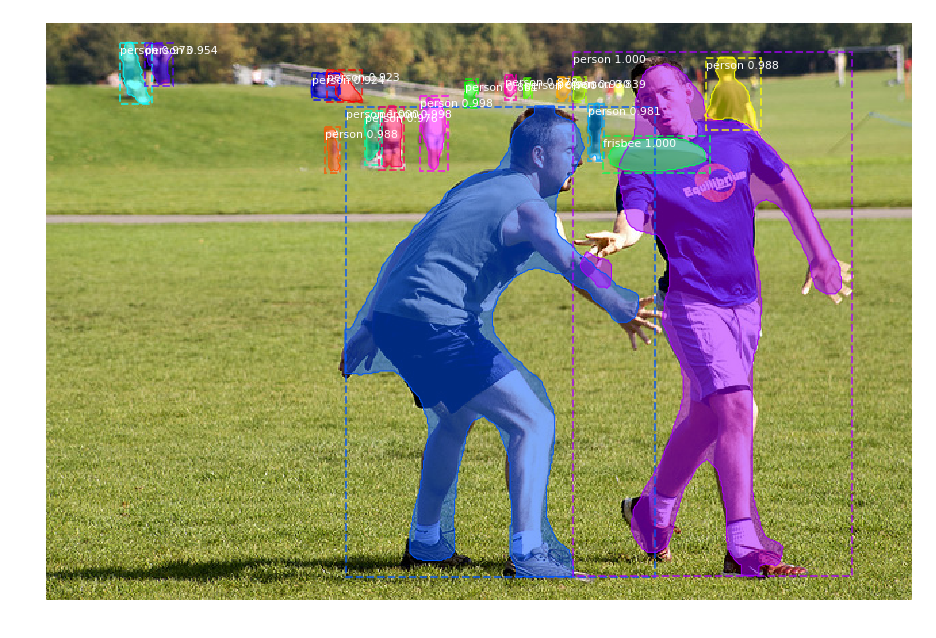

In [11]:
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'])